# Tutorial 8 - LCT in an apertured arm cavity

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg
plt.style.use('user.mplstyle')

import LCT_functions as lctf
import optical_functions as of

## Model parameters

In [2]:
T_ITM = 0.014
T_ETM = 5e-6
R_ITM = 1 - T_ITM
R_ETM = 1 - T_ETM

t_ITM = np.sqrt(T_ITM)
t_ETM = np.sqrt(T_ETM)
r_ITM = np.sqrt(R_ITM)
r_ETM = np.sqrt(R_ETM)

RoC_ITM = 1934
RoC_ETM = 2245
len_ARM = 3994.5
TM_aperture_diam = 32.6e-2
TM_aperture_radius = TM_aperture_diam/2

md = of.abcd_space(len_ARM)
m1 = of.abcd_mirror(RoC_ITM)
m2 = of.abcd_mirror(RoC_ETM)

r_rt = r_ITM*r_ETM
m_rt = m1@md@m2@md
q_eig = of.q_eig(m_rt)
g_rt = of.accum_gouy_Siegman_nm(q_eig, m_rt, n=0, m=0)

## Define input beam

Text(0.5, 0.98, 'Incident beam')

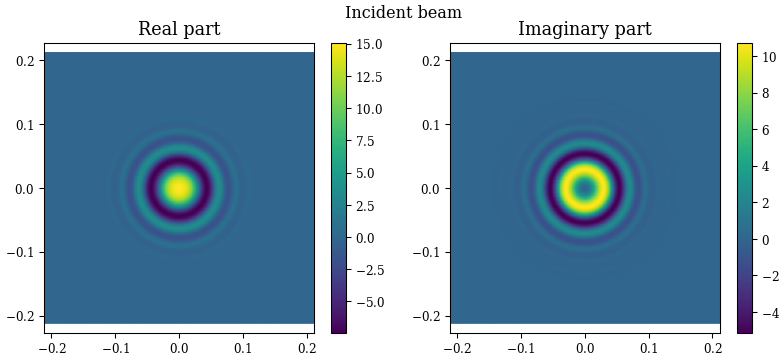

In [3]:
N, M = 201, 202
q_inc = q_eig # input beam is perfectly mode matched
q_to_ETM = of.q_propag(q_inc, md)
w_ITM = of.q2w(q_inc)
w_ETM = of.q2w(q_to_ETM)

xs_ITM = np.linspace(-1, 1, N) * 4*w_ITM
ys_ITM = np.linspace(-1, 1, M) * 4*w_ITM
dx_ITM = xs_ITM[1] - xs_ITM[0]
dy_ITM = ys_ITM[1] - ys_ITM[0]

xs_ETM = np.linspace(-1, 1, N) * 4*w_ETM
ys_ETM = np.linspace(-1, 1, M) * 4*w_ETM
dx_ETM = xs_ETM[1] - xs_ETM[0]
dy_ETM = ys_ETM[1] - ys_ETM[0]

P_in = 1
U_inc = np.sqrt(P_in) * of.u_nm_q(xs_ITM, ys_ITM, q_inc, q_inc, 0, 0)

fig, ax = plt.subplots(1,2,figsize=[10,4])
plt.sca(ax[0])
plt.pcolormesh(xs_ITM,ys_ITM, np.real(U_inc))
plt.axis('equal')
plt.colorbar()
plt.title('Real part')
plt.sca(ax[1])
plt.pcolormesh(xs_ITM,ys_ITM, np.imag(U_inc))
plt.axis('equal')
plt.colorbar()
plt.title('Imaginary part')
plt.suptitle('Incident beam')

## Define aperture mirror map

Text(0.5, 1.0, 'ETM mirror map')

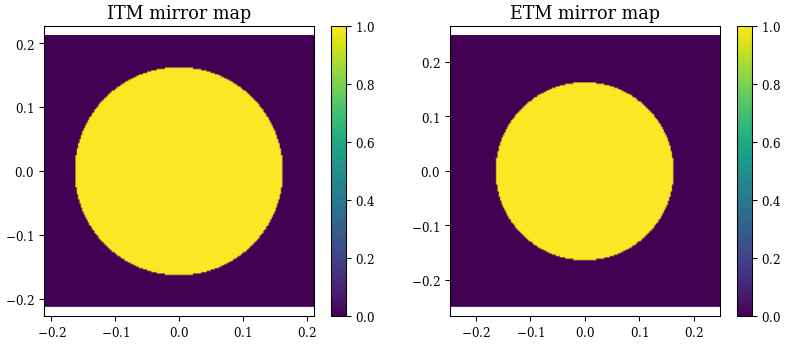

In [4]:
ap_map_ITM = np.ones([M, N], dtype=float)
ap_map_ITM[np.add.outer(ys_ITM**2, xs_ITM**2) > TM_aperture_radius**2] = 0

ap_map_ETM = np.ones([M, N], dtype=float)
ap_map_ETM[np.add.outer(ys_ETM**2, xs_ETM**2) > TM_aperture_radius**2] = 0

fig, ax = plt.subplots(1,2,figsize=[10,4])
plt.sca(ax[0])
plt.pcolormesh(xs_ITM,ys_ITM, ap_map_ITM)
plt.axis('equal')
plt.colorbar()
plt.title('ITM mirror map')
plt.sca(ax[1])
plt.pcolormesh(xs_ETM,ys_ETM, ap_map_ETM)
plt.axis('equal')
plt.colorbar()
plt.title('ETM mirror map')

ETM aperture looks smaller because the grid at the ETM is bigger than it is at the ITM

## Define LCT operators

In [5]:
D_x_ITM_to_ETM = lctf.DLCT(xs_ITM, xs_ETM, M_abcd=md)
D_y_ITM_to_ETM = lctf.DLCT(ys_ITM, ys_ETM, M_abcd=md)

D_x_ETM_to_ITM = lctf.DLCT(xs_ETM, xs_ITM, M_abcd=md)
D_y_ETM_to_ITM = lctf.DLCT(ys_ETM, ys_ITM, M_abcd=md)

C_x_ETM = lctf.CM_kernel(xs_ETM, -2/RoC_ETM, diag=True)
C_y_ETM = lctf.CM_kernel(ys_ETM, -2/RoC_ETM, diag=True)
Rc_map_ETM = np.outer(C_y_ETM, C_x_ETM)

C_x_ITM = lctf.CM_kernel(xs_ITM, -2/RoC_ITM, diag=True)
C_y_ITM = lctf.CM_kernel(ys_ITM, -2/RoC_ITM, diag=True)
Rc_map_ITM = np.outer(C_y_ITM, C_x_ITM)

In [6]:
def op_rt_eig(v):
    '''Round trip operator. Ignore mirror reflectivities for now.
    '''
    Xin = np.reshape(v, [M,N])
    X1 = D_y_ITM_to_ETM@Xin@D_x_ITM_to_ETM.T
    X2 = ap_map_ETM*Rc_map_ETM*X1
    X3 = D_y_ETM_to_ITM@X2@D_x_ETM_to_ITM.T
    X4 = ap_map_ITM*Rc_map_ITM*X3
    return np.ravel(X4)

linop_rt_eig = scipy.sparse.linalg.LinearOperator(matvec=op_rt_eig, shape=[N*M,N*M])

## Compute eigenvalues and eigenvectors of the apertured cavity round trip operator

In [7]:
# this cell can take up to 30 seconds to run

N_eig = 20 # how many cavity eigenmodes to compute

eh, ev = scipy.sparse.linalg.eigs(linop_rt_eig, k=N_eig)

In [8]:
# sort the eigenmodes from lowest to highest loss
idx = np.argsort(np.abs(eh))[::-1]

eh_sorted = eh[idx]
ev_sorted = ev[:,idx]
em_sorted = np.transpose(np.reshape(ev_sorted, [M,N,N_eig]), [2, 0, 1])

Text(0.5, 0.98, 'Lowest loss eigenmode')

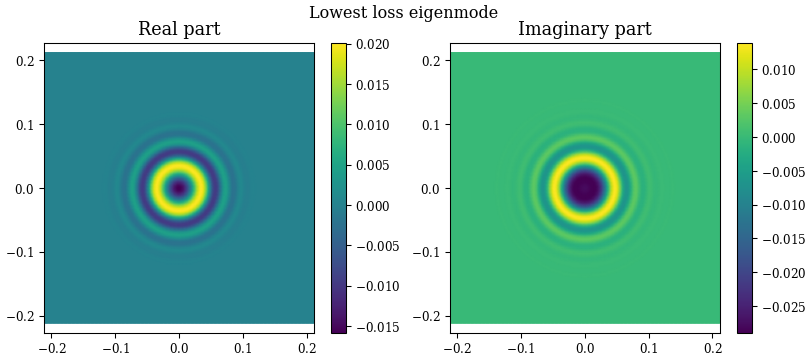

In [9]:
# arnoldi method is not guaranteed to find the HG00 mode
# visually check that the lowest loss eigenmode looks like HG00

fig, ax = plt.subplots(1,2,figsize=[10,4])
plt.sca(ax[0])
plt.pcolormesh(xs_ITM,ys_ITM, np.real(em_sorted[0]))
plt.axis('equal')
plt.colorbar()
plt.title('Real part')
plt.sca(ax[1])
plt.pcolormesh(xs_ITM,ys_ITM, np.imag(em_sorted[0]))
plt.axis('equal')
plt.colorbar()
plt.title('Imaginary part')
plt.suptitle('Lowest loss eigenmode')

Text(0.5, 1.0, 'Intensity distribution')

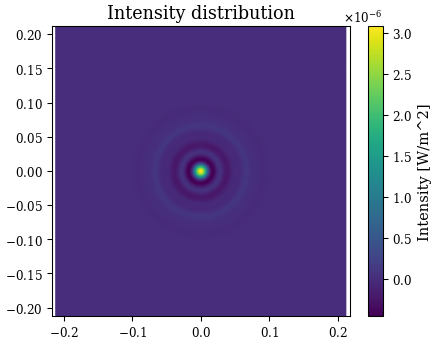

In [10]:
# plot the difference in intensity distributions between the numerical apertured LCT eigenmode and the analytical eigenmode without apertures
analytical_HG00 = of.u_nm_q(xs_ITM, ys_ITM, q_eig, q_eig, 0, 0)
analytical_HG00 = analytical_HG00*np.sqrt(dx_ITM*dy_ITM) # normalize it so it's intensity sums to 1

plt.subplots(figsize=[5,4])
plt.pcolormesh(xs_ITM,ys_ITM, np.abs(em_sorted[0])**2 - np.abs(analytical_HG00)**2)
plt.axis('equal')
cbar = plt.colorbar()
cbar.set_label('Intensity [W/m^2]')
plt.title('Intensity distribution')

In [13]:
# if the lowest loss eigenmode was HG00 then we can print the computed loss and round trip gouy phase

rt_loss_numerical = 1 - np.abs(eh_sorted[0])**2

print()
print(f'Round trip loss due to purely mirror aperutres is {rt_loss_numerical:.4g}')


Round trip loss due to purely mirror aperutres is 1.942e-06


In [14]:
# can also compute the round trip gouy phase from eigenvalue

rt_gouy_analytical = np.angle(g_rt, deg=True)
rt_gouy_numerical = np.angle(eh_sorted[0], deg=True)

print(f'Round trip Gouy phase from ABCD matrices is {rt_gouy_analytical} degrees')
print(f'Round trip Gouy phase from LCT eigenvalue is {rt_gouy_numerical} degrees')
print()
print(f'The difference between LCT eigenvalue and analytical round trip Gouy phase is {(rt_gouy_analytical - rt_gouy_numerical):.4g} degrees')

Round trip Gouy phase from ABCD matrices is -48.660563351072874 degrees
Round trip Gouy phase from LCT eigenvalue is -48.66058177144052 degrees

The difference between LCT eigenvalue and analytical round trip Gouy phase is 1.842e-05 degrees


This difference is likely due to a 'soft' lensing effect from the mirror apertures.

## Compute circulating field on resonance

In [16]:
# normalize the eigenvalue to use it for putting the cavity on resonance
cavity_phase_tuning = np.conj(eh_sorted[0]/np.abs(eh_sorted[0]))

def op_rt(v):
    '''Round trip operator. Put in mirror reflectivities and put the cavity on resonance.
    '''
    Xin = np.reshape(v, [M,N])
    X1 = D_y_ITM_to_ETM@Xin@D_x_ITM_to_ETM.T
    X2 = ap_map_ETM*Rc_map_ETM*X1*r_ETM
    X3 = D_y_ETM_to_ITM@X2@D_x_ETM_to_ITM.T
    X4 = ap_map_ITM*Rc_map_ITM*X3*r_ITM*cavity_phase_tuning
    return np.ravel(X4)

def op_circ(v):
    '''Circulating operator is identity operator minus round trip operator.
    '''
    return v - op_rt(v)

linop_rt = scipy.sparse.linalg.LinearOperator(matvec=op_rt, shape=[N*M,N*M])
linop_circ = scipy.sparse.linalg.LinearOperator(matvec=op_circ, shape=[N*M,N*M])

In [17]:
U_inc_at_ITM = U_inc * 1j*t_ITM * ap_map_ITM

# krylov solvers only take in 1D arrays
U_in = np.ravel(U_inc_at_ITM)

U_circ, _ = scipy.sparse.linalg.gmres(linop_circ, U_in)

# reshape 1D output from krylov solver back into 2D
U_circ = np.reshape(U_circ, [M,N])

In [18]:
incident_power = np.sum(np.abs(U_inc)**2)*dx_ITM*dy_ITM
circulating_power = np.sum(np.abs(U_circ)**2)*dx_ITM*dy_ITM
planewave_circulating_power = (t_ITM/(1-r_ETM*r_ITM))**2

print(f'Incident power onto cavity is {incident_power:.5g} W')
print(f'LCT circulating power inside apertured cavity on resonance is {circulating_power:.5g} W')
print(f'Planewave approximation to circulating power on resonance without apertures is {planewave_circulating_power:.5g} W')

Incident power onto cavity is 1 W
LCT circulating power inside apertured cavity on resonance is 283.43 W
Planewave approximation to circulating power on resonance without apertures is 283.51 W


Text(0.5, 0.98, 'LCT circulating field')

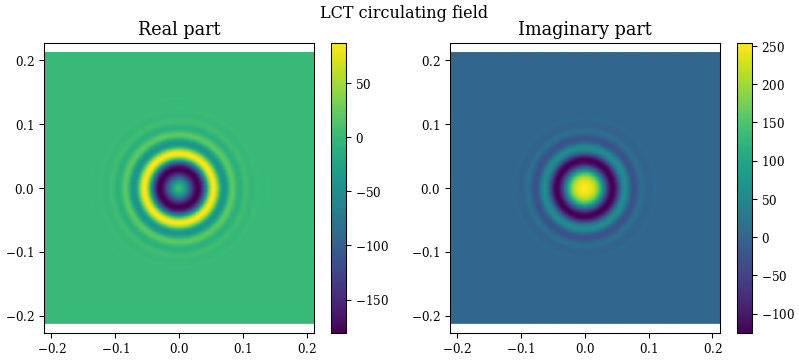

In [20]:
fig, ax = plt.subplots(1,2,figsize=[10,4])
plt.sca(ax[0])
plt.pcolormesh(xs_ITM,ys_ITM, np.real(U_circ))
plt.axis('equal')
plt.colorbar()
plt.title('Real part')
plt.sca(ax[1])
plt.pcolormesh(xs_ITM,ys_ITM, np.imag(U_circ))
plt.axis('equal')
plt.colorbar()
plt.title('Imaginary part')
plt.suptitle('LCT circulating field')

## Propagate circulating field to ETM

In [22]:
# propagate solved field to ETM
U_circ_to_ETM = D_y_ITM_to_ETM@U_circ@D_x_ITM_to_ETM.T

# apply aperture from ETM (ignore curvature and reflection coefficient)
U_circ_from_ETM = ap_map_ETM*U_circ_to_ETM

# compute the difference
U_circ_ETM_to_from_difference = U_circ_to_ETM - U_circ_from_ETM

Text(0.5, 0.98, 'Field to ETM - field from ETM')

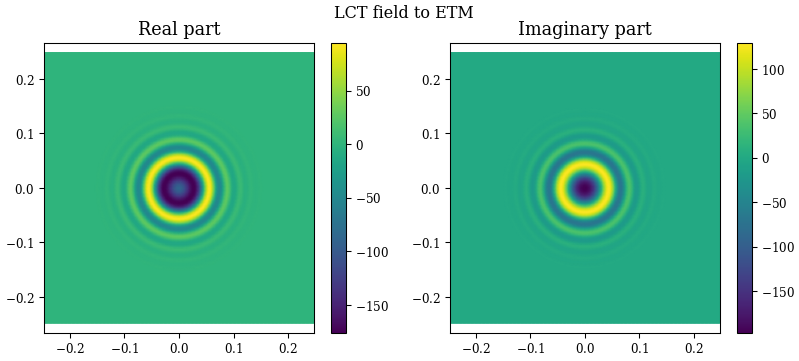

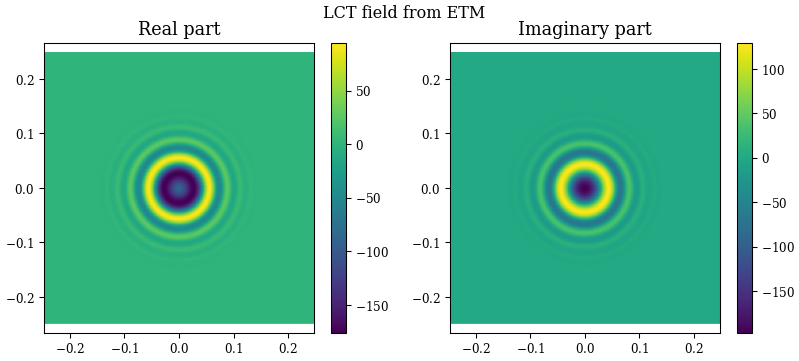

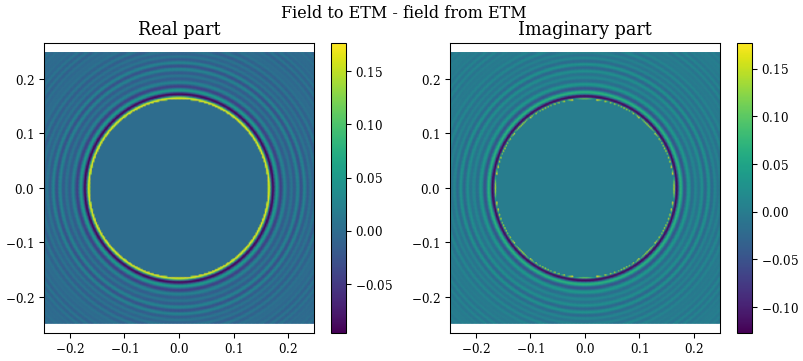

In [25]:
fig, ax = plt.subplots(1,2,figsize=[10,4])
plt.sca(ax[0])
plt.pcolormesh(xs_ETM,ys_ETM, np.real(U_circ_to_ETM))
plt.axis('equal')
plt.colorbar()
plt.title('Real part')
plt.sca(ax[1])
plt.pcolormesh(xs_ETM,ys_ETM, np.imag(U_circ_to_ETM))
plt.axis('equal')
plt.colorbar()
plt.title('Imaginary part')
plt.suptitle('LCT field to ETM')

fig, ax = plt.subplots(1,2,figsize=[10,4])
plt.sca(ax[0])
plt.pcolormesh(xs_ETM,ys_ETM, np.real(U_circ_from_ETM))
plt.axis('equal')
plt.colorbar()
plt.title('Real part')
plt.sca(ax[1])
plt.pcolormesh(xs_ETM,ys_ETM, np.imag(U_circ_from_ETM))
plt.axis('equal')
plt.colorbar()
plt.title('Imaginary part')
plt.suptitle('LCT field from ETM')

fig, ax = plt.subplots(1,2,figsize=[10,4])
plt.sca(ax[0])
plt.pcolormesh(xs_ETM,ys_ETM, np.real(U_circ_ETM_to_from_difference))
plt.axis('equal')
plt.colorbar()
plt.title('Real part')
plt.sca(ax[1])
plt.pcolormesh(xs_ETM,ys_ETM, np.imag(U_circ_ETM_to_from_difference))
plt.axis('equal')
plt.colorbar()
plt.title('Imaginary part')
plt.suptitle('Field to ETM - field from ETM')

## compute power in the diffraction rings on resonance outside of ETM

In [26]:
P_ETM_diffraction_rings = np.sum(np.abs(U_circ_ETM_to_from_difference)**2) * dx_ETM * dy_ETM
P_diffraction_loss = rt_loss_numerical*circulating_power

print(f'Power in ETM diffraction rings is {P_ETM_diffraction_rings:.3e} W')
print(f'Total power lost to due to aperture diffraction {P_diffraction_loss:.3e} W')

Power in ETM diffraction rings is 3.361e-04 W
Total power lost to due to aperture diffraction 5.504e-04 W


The ETM rings power is an estimate since these diffraction rings aren't fully captured in the grid. The loss computed by the eigenvalue should contain the total diffracted power from the ETM and ITM apertures and should be more accurate.